In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(4,maxtasksperchild=1)









1
4
3
2
(1, 829, 517) (60, 829, 517)
(1, 829, 517) (60, 829, 517)
(1, 829, 517) (60, 829, 517)
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
82 (829, 517, 82) (829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(28,) 0.06769826 14.804288
train/valid # (312080, 2) (77550, 2)
82 (829, 517, 82) (829, 517)
(829, 517, 28)
(829, 517, 32)
(829, 517, 28)
(28,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (312080, 2) (77550, 2)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1572
0
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
train/valid 

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(8290, 1, 28) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 252) (8290,) (8290,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(6632, 1, 28) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 252) (6632,) (6632,)
(49444, 252) (49444,) (49444,)
(7461, 1, 28) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 252) (7461,) (7461,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
-1 {'reg_alpha': 0, 'colsample_bytree':

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885525  0.043584  0.261639    7  2017-04-16
472     2.507290  2.250704  0.256587  0.600812    1  2017-04-17
473     2.661330  2.460374  0.200956  0.483885    2  2017-04-18
474     2.754815  2.642485  0.112329  0.350453    3  2017-04-19
475     2.713762  2.624693  0.089069  0.332698    4  2017-04-20
476     2.999000  2.923615  0.075385  0.227042    5  2017-04-21
477     3.075529  3.042393  0.033136  0.257469    6  2017-04-22

0.359142571688


pred         y     error    error2  day        date
dayidx                                                         
471     2.885525  2.929110  0.043584  0.261639    7  2017-04-16
472     2.250704  2.507290  0.256587  0.600812    1  2017-04-17
473     2.460374  2.661330  0.200956  0.483885    2  2017-04-18
474     2.642485  2.754815  0.112329  0.350453    3  2017-04-19
475     2.624693  2.713762  0.089069  0.332698    4  2017-04-20
476     2.923615  2.999000  0.075385  0.227042    5  2017-04-21
477     3.042393  3.075529  0.033136  0.257469    6  2017-04-22

(829, 252)
Stopping. Best iteration:
[256]	train-rmse:0.467113	valid-rmse:0.496075

0.2181945 0.24609007
[0.24609007]
-1 mean score 0.24609007
0.417617350817


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.848381  0.080729  0.297559    7  2017-04-16
472     2.507290  2.471237  0.036053  0.281197    1  2017-04-17
473     2.661330  2.324217  0.337113  0.727025    2  2017-04-18
474     2.754815  2.512223  0.242591  0.533223    3  2017-04-19
475     2.713762  2.588910  0.124852  0.384797    4  2017-04-20
476     2.999000  2.867029  0.131971  0.325568    5  2017-04-21
477     3.075529  2.968678  0.106852  0.373951    6  2017-04-22

0.417617350817


pred         y     error    error2  day        date
dayidx                                                         
471     2.848381  2.929110  0.080729  0.297559    7  2017-04-16
472     2.471237  2.507290  0.036053  0.281197    1  2017-04-17
473     2.324217  2.661330  0.337113  0.727025    2  2017-04-18
474     2.512223  2.754815  0.242591  0.533223    3  2017-04-19
475     2.588910  2.713762  0.124852  0.384797    4  2017-04-20
476     2.867029  2.999000  0.131971  0.325568    5  2017-04-21
477     2.968678  3.075529  0.106852  0.373951    6  2017-04-22

(829, 252)
[350]	train-rmse:0.460242	valid-rmse:0.497418
Stopping. Best iteration:
[308]	train-rmse:0.463676	valid-rmse:0.4973

0.2149957 0.24730742
[0.24730742]
-1 mean score 0.24730742
0.48215124011


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.786877  0.142233  0.464827    7  2017-04-16
472     2.507290  2.508646 -0.001356  0.228123    1  2017-04-17
473     2.661330  2.586749  0.074581  0.314247    2  2017-04-18
474     2.754815  2.366151  0.388663  0.875458    3  2017-04-19
475     2.713762  2.489427  0.224335  0.547768    4  2017-04-20
476     2.999000  2.839375  0.159624  0.390117    5  2017-04-21
477     3.075529  2.905789  0.169740  0.554519    6  2017-04-22

0.48215124011


pred         y     error    error2  day        date
dayidx                                                         
471     2.786877  2.929110  0.142233  0.464827    7  2017-04-16
472     2.508646  2.507290 -0.001356  0.228123    1  2017-04-17
473     2.586749  2.661330  0.074581  0.314247    2  2017-04-18
474     2.366151  2.754815  0.388663  0.875458    3  2017-04-19
475     2.489427  2.713762  0.224335  0.547768    4  2017-04-20
476     2.839375  2.999000  0.159624  0.390117    5  2017-04-21
477     2.905789  3.075529  0.169740  0.554519    6  2017-04-22

(829, 252)
[300]	train-rmse:0.46601	valid-rmse:0.497645
[350]	train-rmse:0.46241	valid-rmse:0.497663
Stopping. Best iteration:
[307]	train-rmse:0.465429	valid-rmse:0.497632

0.21662372 0.24763747
[0.24763747]
-1 mean score 0.24763747
0.196742892265


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909268  0.019841  0.210804    7  2017-04-16
472     2.507290  2.527050 -0.019759  0.201111    1  2017-04-17
473     2.661330  2.654616  0.006713  0.234717    2  2017-04-18
474     2.754815  2.746413  0.008402  0.197428    3  2017-04-19
475     2.713762  2.711838  0.001924  0.219549    4  2017-04-20
476     2.999000  2.987740  0.011260  0.143198    5  2017-04-21
477     3.075529  3.089826 -0.014297  0.170392    6  2017-04-22

0.196742892265


pred         y     error    error2  day        date
dayidx                                                         
471     2.909268  2.929110  0.019841  0.210804    7  2017-04-16
472     2.527050  2.507290 -0.019759  0.201111    1  2017-04-17
473     2.654616  2.661330  0.006713  0.234717    2  2017-04-18
474     2.746413  2.754815  0.008402  0.197428    3  2017-04-19
475     2.711838  2.713762  0.001924  0.219549    4  2017-04-20
476     2.987740  2.999000  0.011260  0.143198    5  2017-04-21
477     3.089826  3.075529 -0.014297  0.170392    6  2017-04-22

(829, 252)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



5
(1, 829, 517) (60, 829, 517)


6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(28,) 0.06769826 15.133374
(829, 517, 28)
(829, 517, 28)
(829, 517, 32)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1572
0
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(9948, 1, 28) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 252) (9948,) (9948,)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
(9119, 1, 28) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 252) (9119,) (9119,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


7
(1, 829, 517) (60, 829, 517)
[0]	train-rmse:2.38217	valid-rmse:2.42237
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't i

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(10777, 1, 28) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 252) (10777,) (10777,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39816	valid-rmse:2.4387
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.983199	valid-rmse:0.996577


8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 17.574337
[50]	train-rmse:0.984422	valid-rmse:0.998907
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(11606, 1, 28) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 252) (11606,) (11606,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[50]	train-rmse:0.987107	valid-rmse:1.00016
[0]	train-rmse:2.41055	valid-rmse:2.45197
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.577758	valid-rmse:0.58949
[100]	train-rmse:0.576754	valid-rmse:0.589632
[50]	train-rmse:0.990382	valid-rmse:1.00336
[100]	train-rmse:0.57663	valid-rmse:0.588602
[150]	train-rmse:0.494299	valid-rmse:0.512511
[150]	train-rmse:0.492822	valid-rmse:0.511843
[200]	train-rmse:0.477481	valid-rmse:0.501828
[150]	train-rmse:0.491845	valid-rmse:0.5108

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.718644  0.210466  0.577374    7  2017-04-16
472     2.507290  2.383786  0.123504  0.421734    1  2017-04-17
473     2.661330  2.565695  0.095635  0.354102    2  2017-04-18
474     2.754815  2.707311  0.047504  0.228519    3  2017-04-19
475     2.713762  2.641370  0.072392  0.325191    4  2017-04-20
476     2.999000  2.563630  0.435370  1.003156    5  2017-04-21
477     3.075529  2.735594  0.339935  0.815538    6  2017-04-22

0.532230615616


pred         y     error    error2  day        date
dayidx                                                         
471     2.718644  2.929110  0.210466  0.577374    7  2017-04-16
472     2.383786  2.507290  0.123504  0.421734    1  2017-04-17
473     2.565695  2.661330  0.095635  0.354102    2  2017-04-18
474     2.707311  2.754815  0.047504  0.228519    3  2017-04-19
475     2.641370  2.713762  0.072392  0.325191    4  2017-04-20
476     2.563630  2.999000  0.435370  1.003156    5  2017-04-21
477     2.735594  3.075529  0.339935  0.815538    6  2017-04-22

(829, 252)


9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 18.806503
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[250]	train-rmse:0.470369	valid-rmse:0.499622
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(12435, 1, 28) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 252) (12435,) (12435,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40982	valid-rmse:2.45218
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[300]	train-rmse:0.464577	valid-rmse:0.498912
[200]	train-rmse:0.473756	valid-rmse:0.495907
[300]	train-rmse:0.465934	valid-rmse:0.499629
Stopping. Best iteration:
[273]	train-rmse:0.467098	valid-rmse:0.49888

0.21818034 0.24888085
[0.24888085]
-1 mean score 0.24888085
0.439804077148


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.591135  0.337975  0.788348    7  2017-04-16
472     2.507290  2.454324  0.052967  0.329153    1  2017-04-17
473     2.661330  2.521253  0.140077  0.423563    2  2017-04-18
474     2.754815  2.660519  0.094296  0.320840    3  2017-04-19
475     2.713762  2.683459  0.030302  0.266874    4  2017-04-20
476     2.999000  2.912097  0.086902  0.262410    5  2017-04-21
477     3.075529  2.779261  0.296269  0.687439    6  2017-04-22

0.439804077148


pred         y     error    error2  day        date
dayidx                                                         
471     2.591135  2.929110  0.337975  0.788348    7  2017-04-16
472     2.454324  2.507290  0.052967  0.329153    1  2017-04-17
473     2.521253  2.661330  0.140077  0.423563    2  2017-04-18
474     2.660519  2.754815  0.094296  0.320840    3  2017-04-19
475     2.683459  2.713762  0.030302  0.266874    4  2017-04-20
476     2.912097  2.999000  0.086902  0.262410    5  2017-04-21
477     2.779261  3.075529  0.296269  0.687439    6  2017-04-22

(829, 252)


10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 19.926521
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


Stopping. Best iteration:
[285]	train-rmse:0.467203	valid-rmse:0.499578

(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(13264, 1, 28) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 252) (13264,) (13264,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
0.21827859 0.24957804
[0.24957804]
-1 mean score 0.24957804
0.460747897625


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.691711  0.237398  0.622436    7  2017-04-16
472     2.507290  2.460781  0.046509  0.293174    1  2017-04-17
473     2.661330  2.615834  0.045495  0.260838    2  2017-04-18
474     2.754815  2.668904  0.085911  0.287506    3  2017-04-19
475     2.713762  2.388218  0.325543  0.716354    4  2017-04-20
476     2.999000  2.726544  0.272456  0.539280    5  2017-04-21
477     3.075529  2.909711  0.165818  0.505648    6  2017-04-22

0.460747897625


pred         y     error    error2  day        date
dayidx                                                         
471     2.691711  2.929110  0.237398  0.622436    7  2017-04-16
472     2.460781  2.507290  0.046509  0.293174    1  2017-04-17
473     2.615834  2.661330  0.045495  0.260838    2  2017-04-18
474     2.668904  2.754815  0.085911  0.287506    3  2017-04-19
475     2.388218  2.713762  0.325543  0.716354    4  2017-04-20
476     2.726544  2.999000  0.272456  0.539280    5  2017-04-21
477     2.909711  3.075529  0.165818  0.505648    6  2017-04-22

(829, 252)


11
(1, 829, 517) (60, 829, 517)
[0]	train-rmse:2.401	valid-rmse:2.4457
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 21.05768
[50]	train-rmse:0.992715	valid-rmse:1.00542
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[250]	train-rmse:0.467993	valid-rmse:0.494628
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(14093, 1, 28) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 252) (14093,) (14093,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39379	valid-rmse:2.43409
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[300]	train-rmse:0.463497	valid-rmse:0.4945
[100]	train-rmse:0.580532	valid-rmse:0.59169
[50]	train-rmse:0.991416	valid-rmse:1.00624
[50]	train-rmse:0.989552	valid-rmse:1.00065
Stopping. Best iteration:
[298]	train-rmse:0.463658	valid-rmse:0.494488

0.21497843 0.2445188
[0.2445188]
-1 mean score 0.2445188
0.2555077672


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.855023  0.074087  0.303324    7  2017-04-16
472     2.507290  2.492876  0.014414  0.265079    1  2017-04-17
473     2.661330  2.608195  0.053135  0.277046    2  2017-04-18
474     2.754815  2.686291  0.068524  0.278334    3  2017-04-19
475     2.713762  2.684856  0.028906  0.269559    4  2017-04-20
476     2.999000  2.948561  0.050439  0.178775    5  2017-04-21
477     3.075529  3.053647  0.021882  0.216437    6  2017-04-22

0.2555077672


pred         y     error    error2  day        date
dayidx                                                         
471     2.855023  2.929110  0.074087  0.303324    7  2017-04-16
472     2.492876  2.507290  0.014414  0.265079    1  2017-04-17
473     2.608195  2.661330  0.053135  0.277046    2  2017-04-18
474     2.686291  2.754815  0.068524  0.278334    3  2017-04-19
475     2.684856  2.713762  0.028906  0.269559    4  2017-04-20
476     2.948561  2.999000  0.050439  0.178775    5  2017-04-21
477     3.053647  3.075529  0.021882  0.216437    6  2017-04-22

(829, 252)


12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 22.115147
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1572
0
[150]	train-rmse:0.495388	valid-rmse:0.513604
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(14922, 1, 28) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 252) (14922,) (14922,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[100]	train-rmse:0.582898	valid-rmse:0.594969
[0]	train-rmse:2.38864	valid-rmse:2.43114
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.583222	valid-rmse:0.592995
[200]	train-rmse:0.47813	valid-rmse:0.502928
[150]	train-rmse:0.498493	valid-rmse:0.516878
[50]	train-rmse:0.988478	valid-rmse:1.00326
[150]	train-rmse:0.499605	valid-rmse:0.51687
[250]	train-rmse:0.472639	valid-rmse:0.501735
[200]	train-rmse:0.4816	valid-rmse:0.506038
[100]	train-rmse:0.583997	valid-rmse:0.5971

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878312  0.050798  0.289945    7  2017-04-16
472     2.507290  2.220806  0.286484  0.695860    1  2017-04-17
473     2.661330  2.472858  0.188472  0.487626    2  2017-04-18
474     2.754815  2.637882  0.116932  0.357213    3  2017-04-19
475     2.713762  2.606637  0.107125  0.385026    4  2017-04-20
476     2.999000  2.905486  0.093514  0.245885    5  2017-04-21
477     3.075529  3.048309  0.027221  0.237272    6  2017-04-22

0.385546892881


pred         y     error    error2  day        date
dayidx                                                         
471     2.878312  2.929110  0.050798  0.289945    7  2017-04-16
472     2.220806  2.507290  0.286484  0.695860    1  2017-04-17
473     2.472858  2.661330  0.188472  0.487626    2  2017-04-18
474     2.637882  2.754815  0.116932  0.357213    3  2017-04-19
475     2.606637  2.713762  0.107125  0.385026    4  2017-04-20
476     2.905486  2.999000  0.093514  0.245885    5  2017-04-21
477     3.048309  3.075529  0.027221  0.237272    6  2017-04-22

(829, 252)


13
(1, 829, 517) (60, 829, 517)
[250]	train-rmse:0.477027	valid-rmse:0.505647
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 23.15517
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[150]	train-rmse:0.500816	valid-rmse:0.520747
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1572
0
[300]	train-rmse:0.471162	valid-rmse:0.504764
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(15751, 1, 28) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 252) (15751,) (15751,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
Stopping. Best iteration:
[262]	train-rmse:0.474533	valid-rmse:0.504685

0.2251813 0.2547072
[0.2547072]
-1 mean score 0.2547072
0.435169368982


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.846424  0.082686  0.320293    7  2017-04-16
472     2.507290  2.473684  0.033606  0.292548    1  2017-04-17
473     2.661330  2.303705  0.357624  0.770470    2  2017-04-18
474     2.754815  2.498202  0.256612  0.555757    3  2017-04-19
475     2.713762  2.609999  0.103763  0.345743    4  2017-04-20
476     2.999000  2.821872  0.177128  0.364887    5  2017-04-21
477     3.075529  2.970974  0.104555  0.396488    6  2017-04-22

0.435169368982


pred         y     error    error2  day        date
dayidx                                                         
471     2.846424  2.929110  0.082686  0.320293    7  2017-04-16
472     2.473684  2.507290  0.033606  0.292548    1  2017-04-17
473     2.303705  2.661330  0.357624  0.770470    2  2017-04-18
474     2.498202  2.754815  0.256612  0.555757    3  2017-04-19
475     2.609999  2.713762  0.103763  0.345743    4  2017-04-20
476     2.821872  2.999000  0.177128  0.364887    5  2017-04-21
477     2.970974  3.075529  0.104555  0.396488    6  2017-04-22

(829, 252)


14
(1, 829, 517) (60, 829, 517)
[0]	train-rmse:2.38205	valid-rmse:2.42246
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 24.22639
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(16580, 1, 28) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 252) (16580,) (16580,)
[300]	train-rmse:0.471904	valid-rmse:0.505672
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[200]	train-rmse:0.484027	valid-rmse:0.510177
Stopping. Best iteration:
[251]	train-rmse:0.476947	valid-rmse:0.505642

0.22747798 0.25567356
[0.25567356]
-1 mean score 0.25567356
0.508344471455


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.749697  0.179413  0.508569    7  2017-04-16
472     2.507290  2.497754  0.009537  0.248732    1  2017-04-17
473     2.661330  2.581870  0.079460  0.332717    2  2017-04-18
474     2.754815  2.336601  0.418214  0.876237    3  2017-04-19
475     2.713762  2.483417  0.230344  0.568199    4  2017-04-20
476     2.999000  2.828744  0.170255  0.382362    5  2017-04-21
477     3.075529  2.853688  0.221841  0.641596    6  2017-04-22

0.508344471455


pred         y     error    error2  day        date
dayidx                                                         
471     2.749697  2.929110  0.179413  0.508569    7  2017-04-16
472     2.497754  2.507290  0.009537  0.248732    1  2017-04-17
473     2.581870  2.661330  0.079460  0.332717    2  2017-04-18
474     2.336601  2.754815  0.418214  0.876237    3  2017-04-19
475     2.483417  2.713762  0.230344  0.568199    4  2017-04-20
476     2.828744  2.999000  0.170255  0.382362    5  2017-04-21
477     2.853688  3.075529  0.221841  0.641596    6  2017-04-22

(829, 252)


15
(1, 829, 517) (60, 829, 517)
[0]	train-rmse:2.39779	valid-rmse:2.43948
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 25.357664
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1572
0
[50]	train-rmse:0.98695	valid-rmse:0.999472
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(17409, 1, 28) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 252) (17409,) (17409,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41038	valid-rmse:2.45135
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[250]	train-rmse:0.477924	valid-rmse:0.508883
[50]	train-rmse:0.990113	valid-rmse:1.00371
[300]	train-rmse:0.472841	valid-rmse:0.508804
[100]	train-rmse:0.584611	valid-rmse:0.595045
[50]	train-rmse:0.993513	valid-rmse:1.00546
Stopping. Best iteration:
[278]	train-rmse:0.474961	valid-rmse:0.508772

0.22558828 0.25884888
[0.25884888]
-1 mean score 0.25884888
0.471088945866


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.723328  0.205782  0.559755    7  2017-04-16
472     2.507290  2.458586  0.048705  0.313155    1  2017-04-17
473     2.661330  2.625053  0.036277  0.290515    2  2017-04-18
474     2.754815  2.666588  0.088227  0.301923    3  2017-04-19
475     2.713762  2.367352  0.346410  0.788934    4  2017-04-20
476     2.999000  2.720567  0.278432  0.554589    5  2017-04-21
477     3.075529  2.915260  0.160269  0.488752    6  2017-04-22

0.471088945866


pred         y     error    error2  day        date
dayidx                                                         
471     2.723328  2.929110  0.205782  0.559755    7  2017-04-16
472     2.458586  2.507290  0.048705  0.313155    1  2017-04-17
473     2.625053  2.661330  0.036277  0.290515    2  2017-04-18
474     2.666588  2.754815  0.088227  0.301923    3  2017-04-19
475     2.367352  2.713762  0.346410  0.788934    4  2017-04-20
476     2.720567  2.999000  0.278432  0.554589    5  2017-04-21
477     2.915260  3.075529  0.160269  0.488752    6  2017-04-22

(829, 252)


16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 26.465925
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1572
0
[100]	train-rmse:0.582283	valid-rmse:0.594313
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(18238, 1, 28) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 252) (18238,) (18238,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40999	valid-rmse:2.45043
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[150]	train-rmse:0.502017	valid-rmse:0.519132
[100]	train-rmse:0.582266	valid-rmse:0.590733
[150]	train-rmse:0.498055	valid-rmse:0.517277
[200]	train-rmse:0.485322	valid-rmse:0.508741
[50]	train-rmse:0.995866	valid-rmse:1.0079
[150]	train-rmse:0.497272	valid-rmse:0.512001
[200]	train-rmse:0.4812	valid-rmse:0.506716
[250]	train-rmse:0.47936	valid-rmse:0.507603
[250]	train-rmse:0.474997	valid-rmse:0.5056

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.688028  0.241082  0.637114    7  2017-04-16
472     2.507290  2.413428  0.093862  0.375033    1  2017-04-17
473     2.661330  2.570884  0.090446  0.376477    2  2017-04-18
474     2.754815  2.701086  0.053729  0.264040    3  2017-04-19
475     2.713762  2.661806  0.051956  0.309410    4  2017-04-20
476     2.999000  2.546440  0.452560  0.983908    5  2017-04-21
477     3.075529  2.749174  0.326355  0.795716    6  2017-04-22

0.534528374672


pred         y     error    error2  day        date
dayidx                                                         
471     2.688028  2.929110  0.241082  0.637114    7  2017-04-16
472     2.413428  2.507290  0.093862  0.375033    1  2017-04-17
473     2.570884  2.661330  0.090446  0.376477    2  2017-04-18
474     2.701086  2.754815  0.053729  0.264040    3  2017-04-19
475     2.661806  2.713762  0.051956  0.309410    4  2017-04-20
476     2.546440  2.999000  0.452560  0.983908    5  2017-04-21
477     2.749174  3.075529  0.326355  0.795716    6  2017-04-22

(829, 252)


17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 27.605818
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[150]	train-rmse:0.501853	valid-rmse:0.521121
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1572
0
Stopping. Best iteration:
[277]	train-rmse:0.4718	valid-rmse:0.50557

0.22259517 0.2556008
[0.2556008]
-1 mean score 0.2556008
0.415308505297


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.599087  0.330023  0.759452    7  2017-04-16
472     2.507290  2.433868  0.073422  0.332105    1  2017-04-17
473     2.661330  2.559203  0.102127  0.362750    2  2017-04-18
474     2.754815  2.664699  0.090116  0.309222    3  2017-04-19
475     2.713762  2.703221  0.010541  0.257007    4  2017-04-20
476     2.999000  2.928046  0.070954  0.231564    5  2017-04-21
477     3.075529  2.771290  0.304239  0.655060    6  2017-04-22

(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
0.415308505297


pred         y     error    error2  day        date
dayidx                                                         
471     2.599087  2.929110  0.330023  0.759452    7  2017-04-16
472     2.433868  2.507290  0.073422  0.332105    1  2017-04-17
473     2.559203  2.661330  0.102127  0.362750    2  2017-04-18
474     2.664699  2.754815  0.090116  0.309222    3  2017-04-19
475     2.703221  2.713762  0.010541  0.257007    4  2017-04-20
476     2.928046  2.999000  0.070954  0.231564    5  2017-04-21
477     2.771290  3.075529  0.304239  0.655060    6  2017-04-22

(829, 252)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  




18
(1, 829, 517) (60, 829, 517)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(19067, 1, 28) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 252) (19067,) (19067,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 28.75126
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[0]	train-rmse:2.40079	valid-rmse:2.44609
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(19896, 1, 28) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 252) (19896,) (19896,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39205	valid-rmse:2.4359
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[200]	train-rmse:0.484718	valid-rmse:0.51081
Stopping. Best iteration:
[297]	train-rmse:0.469477	valid-rmse:0.49968

0.22040884 0.24968031
[0.24968031]
-1 mean score 0.24968031
0.250373512506


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.850599  0.078511  0.303303    7  2017-04-16
472     2.507290  2.491498  0.015792  0.259529    1  2017-04-17
473     2.661330  2.608054  0.053276  0.315069    2  2017-04-18
474     2.754815  2.704602  0.050212  0.257018    3  2017-04-19
475     2.713762  2.701229  0.012533  0.244483    4  2017-04-20
476     2.999000  2.964716  0.034284  0.173075    5  2017-04-21
477     3.075529  3.059471  0.016058  0.200136    6  2017-04-22

0.250373512506


pred         y     error    error2  day        date
dayidx                                                         
471     2.850599  2.929110  0.078511  0.303303    7  2017-04-16
472     2.491498  2.507290  0.015792  0.259529    1  2017-04-17
473     2.608054  2.661330  0.053276  0.315069    2  2017-04-18
474     2.704602  2.754815  0.050212  0.257018    3  2017-04-19
475     2.701229  2.713762  0.012533  0.244483    4  2017-04-20
476     2.964716  2.999000  0.034284  0.173075    5  2017-04-21
477     3.059471  3.075529  0.016058  0.200136    6  2017-04-22

(829, 252)


19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 29.798643
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1572
0
[50]	train-rmse:0.993926	valid-rmse:1.00973
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[250]	train-rmse:0.478499	valid-rmse:0.509735
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(20725, 1, 28) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 252) (20725,) (20725,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[50]	train-rmse:0.991517	valid-rmse:1.00566
[0]	train-rmse:2.387	valid-rmse:2.42898
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[300]	train-rmse:0.473737	valid-rmse:0.509753
[100]	train-rmse:0.587431	valid-rmse:0.600995
Stopping. Best iteration:
[277]	train-rmse:0.475657	valid-rmse:0.509717

0.22624947 0.2598111
[0.2598111]
-1 mean score 0.2598111
0.363301903009


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.849644  0.079466  0.313299    7  2017-04-16
472     2.507290  2.273363  0.233927  0.572949    1  2017-04-17
473     2.661330  2.488396  0.172934  0.452595    2  2017-04-18
474     2.754815  2.620340  0.134475  0.367957    3  2017-04-19
475     2.713762  2.638955  0.074806  0.329803    4  2017-04-20
476     2.999000  2.904295  0.094705  0.246845    5  2017-04-21
477     3.075529  3.029038  0.046492  0.259666    6  2017-04-22

[100]	train-rmse:0.587606	valid-rmse:0.599367
0.363301903009


pred         y     error    error2  day        date
dayidx                                                         
471     2.849644  2.929110  0.079466  0.313299    7  2017-04-16
472     2.273363  2.507290  0.233927  0.572949    1  2017-04-17
473     2.488396  2.661330  0.172934  0.452595    2  2017-04-18
474     2.620340  2.754815  0.134475  0.367957    3  2017-04-19
475     2.638955  2.713762  0.074806  0.329803    4  2017-04-20
476     2.904295  2.999000  0.094705  0.246845    5  2017-04-21
477     3.029038  3.075529  0.046492  0.259666    6  2017-04-22

(829, 252)


20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 30.796307
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1572
0
[50]	train-rmse:0.989676	valid-rmse:1.00524
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(21554, 1, 28) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 252) (21554,) (21554,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38051	valid-rmse:2.42158
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[150]	train-rmse:0.50372	valid-rmse:0.523777
[150]	train-rmse:0.504391	valid-rmse:0.523166
[200]	train-rmse:0.486543	valid-rmse:0.512978
[100]	train-rmse:0.586773	valid-rmse:0.601601
[200]	train-rmse:0.487197	valid-rmse:0.512728
[50]	train-rmse:0.988704	valid-rmse:1.00347
[250]	train-rmse:0.47996	valid-rmse:0.511708
[250]	train-rmse:0.480734	valid-rmse:0.511557
[150]	train-rmse:0.5039	valid-rmse:0.5255

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.795708  0.133402  0.445186    7  2017-04-16
472     2.507290  2.495758  0.011533  0.253369    1  2017-04-17
473     2.661330  2.582039  0.079291  0.344822    2  2017-04-18
474     2.754815  2.400141  0.354674  0.727911    3  2017-04-19
475     2.713762  2.523083  0.190678  0.497612    4  2017-04-20
476     2.999000  2.844856  0.154144  0.363401    5  2017-04-21
477     3.075529  2.907368  0.168161  0.474451    6  2017-04-22

0.443821907043


pred         y     error    error2  day        date
dayidx                                                         
471     2.795708  2.929110  0.133402  0.445186    7  2017-04-16
472     2.495758  2.507290  0.011533  0.253369    1  2017-04-17
473     2.582039  2.661330  0.079291  0.344822    2  2017-04-18
474     2.400141  2.754815  0.354674  0.727911    3  2017-04-19
475     2.523083  2.713762  0.190678  0.497612    4  2017-04-20
476     2.844856  2.999000  0.154144  0.363401    5  2017-04-21
477     2.907368  3.075529  0.168161  0.474451    6  2017-04-22

(829, 252)


21
(1, 829, 517) (60, 829, 517)
[350]	train-rmse:0.470199	valid-rmse:0.511801
Stopping. Best iteration:
[305]	train-rmse:0.474054	valid-rmse:0.511664

82 (829, 517, 82) (829, 517)
(28,) 0.06769826 31.792852
(829, 517, 28)
(829, 517, 32)
0.2247268 0.2618004
[0.2618004]
-1 mean score 0.2618004
0.444907486439


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.839308  0.089802  0.346243    7  2017-04-16
472     2.507290  2.466922  0.040368  0.309711    1  2017-04-17
473     2.661330  2.308184  0.353146  0.776533    2  2017-04-18
474     2.754815  2.508690  0.246124  0.550259    3  2017-04-19
475     2.713762  2.607037  0.106724  0.384746    4  2017-04-20
476     2.999000  2.860944  0.138056  0.341475    5  2017-04-21
477     3.075529  2.955045  0.120484  0.405386    6  2017-04-22

train/valid # (312080, 2) (77550, 2)
0.444907486439


pred         y     error    error2  day        date
dayidx                                                         
471     2.839308  2.929110  0.089802  0.346243    7  2017-04-16
472     2.466922  2.507290  0.040368  0.309711    1  2017-04-17
473     2.308184  2.661330  0.353146  0.776533    2  2017-04-18
474     2.508690  2.754815  0.246124  0.550259    3  2017-04-19
475     2.607037  2.713762  0.106724  0.384746    4  2017-04-20
476     2.860944  2.999000  0.138056  0.341475    5  2017-04-21
477     2.955045  3.075529  0.120484  0.405386    6  2017-04-22

(829, 252)


22
(1, 829, 517) (60, 829, 517)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1572
0
[150]	train-rmse:0.506486	valid-rmse:0.526831
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 32.870983
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(22383, 1, 28) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 252) (22383,) (22383,)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1572
0
[250]	train-rmse:0.480534	valid-rmse:0.513686
[0]	train-rmse:2.39629	valid-rmse:2.43757
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(23212, 1, 28) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 252) (23212,) (23212,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4101	valid-rmse:2.4512
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[200]	train-rmse:0.489811	valid-rmse:0.516336
[300]	train-rmse:0.475334	valid-rmse:0.513586
[250]	train-rmse:0.483499	valid-rmse:0.515087
[50]	train-rmse:0.992078	valid-rmse:1.00568
[50]	train-rmse:0.995104	valid-rmse:1.00748
[350]	train-rmse:0.470905	valid-rmse:0.513647
Stopping. Best iteration:
[304]	train-rmse:0.474998	valid-rmse:0.513556

0.225623 0.2637398
[0.2637398]
-1 mean score 0.2637398
0.48296

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.723149  0.205961  0.605131    7  2017-04-16
472     2.507290  2.472679  0.034611  0.291564    1  2017-04-17
473     2.661330  2.612885  0.048445  0.316346    2  2017-04-18
474     2.754815  2.650473  0.104341  0.339502    3  2017-04-19
475     2.713762  2.377398  0.336364  0.768232    4  2017-04-20
476     2.999000  2.724632  0.274368  0.554788    5  2017-04-21
477     3.075529  2.890076  0.185453  0.505175    6  2017-04-22

0.48296263814


pred         y     error    error2  day        date
dayidx                                                         
471     2.723149  2.929110  0.205961  0.605131    7  2017-04-16
472     2.472679  2.507290  0.034611  0.291564    1  2017-04-17
473     2.612885  2.661330  0.048445  0.316346    2  2017-04-18
474     2.650473  2.754815  0.104341  0.339502    3  2017-04-19
475     2.377398  2.713762  0.336364  0.768232    4  2017-04-20
476     2.724632  2.999000  0.274368  0.554788    5  2017-04-21
477     2.890076  3.075529  0.185453  0.505175    6  2017-04-22

(829, 252)


23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 33.974537
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1572
0
[300]	train-rmse:0.478679	valid-rmse:0.51503
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(24041, 1, 28) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 252) (24041,) (24041,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40911	valid-rmse:2.45103
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[293]	train-rmse:0.479269	valid-rmse:0.515022

0.22969918 0.26524726
[0.26524726]
-1 mean score 0.26524726
0.515353024006
[100]	train-rmse:0.584974	valid-rmse:0.595782


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.711087  0.218023  0.623508    7  2017-04-16
472     2.507290  2.411246  0.096045  0.373794    1  2017-04-17
473     2.661330  2.580706  0.080624  0.353758    2  2017-04-18
474     2.754815  2.678637  0.076178  0.287737    3  2017-04-19
475     2.713762  2.650263  0.063499  0.315595    4  2017-04-20
476     2.999000  2.565401  0.433599  0.915007    5  2017-04-21
477     3.075529  2.756534  0.318996  0.738071    6  2017-04-22

0.515353024006


pred         y     error    error2  day        date
dayidx                                                         
471     2.711087  2.929110  0.218023  0.623508    7  2017-04-16
472     2.411246  2.507290  0.096045  0.373794    1  2017-04-17
473     2.580706  2.661330  0.080624  0.353758    2  2017-04-18
474     2.678637  2.754815  0.076178  0.287737    3  2017-04-19
475     2.650263  2.713762  0.063499  0.315595    4  2017-04-20
476     2.565401  2.999000  0.433599  0.915007    5  2017-04-21
477     2.756534  3.075529  0.318996  0.738071    6  2017-04-22

(829, 252)


24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
[100]	train-rmse:0.58654	valid-rmse:0.598775
(28,) 0.06769826 35.208443
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(24870, 1, 28) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 252) (24870,) (24870,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39923	valid-rmse:2.44528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997314	valid-rmse:1.01019
[150]	train-rmse:0.500063	valid-rmse:0.518453
[150]	train-rmse:0.502954	valid-rmse:0.522353
[100]	train-rmse:0.589271	valid-rmse:0.601593
[200]	train-rmse:0.482813	valid-rmse:0.507951
[50]	train-rmse:0.994927	valid-rmse:1.0113
[200]	train-rmse:0.485597	valid-rmse:0.511792
[250]	train-rmse:0.476386	valid-rmse:0.506808
[150]	train-rmse:0.505029	valid-rmse:0.525

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.847197  0.081913  0.325560    7  2017-04-16
472     2.507290  2.494393  0.012897  0.256473    1  2017-04-17
473     2.661330  2.612687  0.048643  0.310923    2  2017-04-18
474     2.754815  2.698256  0.056559  0.272182    3  2017-04-19
475     2.713762  2.693758  0.020004  0.258380    4  2017-04-20
476     2.999000  2.933604  0.065396  0.217191    5  2017-04-21
477     3.075529  3.031961  0.043568  0.222419    6  2017-04-22

0.266161084175


pred         y     error    error2  day        date
dayidx                                                         
471     2.847197  2.929110  0.081913  0.325560    7  2017-04-16
472     2.494393  2.507290  0.012897  0.256473    1  2017-04-17
473     2.612687  2.661330  0.048643  0.310923    2  2017-04-18
474     2.698256  2.754815  0.056559  0.272182    3  2017-04-19
475     2.693758  2.713762  0.020004  0.258380    4  2017-04-20
476     2.933604  2.999000  0.065396  0.217191    5  2017-04-21
477     3.031961  3.075529  0.043568  0.222419    6  2017-04-22

(829, 252)


25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 36.335064
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1572
0
[150]	train-rmse:0.506026	valid-rmse:0.527883
[300]	train-rmse:0.473843	valid-rmse:0.510665
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(25699, 1, 28) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 252) (25699,) (25699,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
Stopping. Best iteration:
[257]	train-rmse:0.478212	valid-rmse:0.510616

0.22868691 0.26072896
[0.26072896]
-1 mean score 0.26072896
0.400033473969


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.644917  0.284193  0.656971    7  2017-04-16
472     2.507290  2.450569  0.056722  0.314925    1  2017-04-17
473     2.661330  2.561784  0.099546  0.373255    2  2017-04-18
474     2.754815  2.661981  0.092834  0.309786    3  2017-04-19
475     2.713762  2.664843  0.048919  0.279112    4  2017-04-20
476     2.999000  2.894906  0.104094  0.271477    5  2017-04-21
477     3.075529  2.776711  0.298818  0.594708    6  2017-04-22

0.400033473969


pred         y     error    error2  day        date
dayidx                                                         
471     2.644917  2.929110  0.284193  0.656971    7  2017-04-16
472     2.450569  2.507290  0.056722  0.314925    1  2017-04-17
473     2.561784  2.661330  0.099546  0.373255    2  2017-04-18
474     2.661981  2.754815  0.092834  0.309786    3  2017-04-19
475     2.664843  2.713762  0.048919  0.279112    4  2017-04-20
476     2.894906  2.999000  0.104094  0.271477    5  2017-04-21
477     2.776711  3.075529  0.298818  0.594708    6  2017-04-22

(829, 252)


26
[0]	train-rmse:2.3914	valid-rmse:2.43528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
(1, 829, 517) (60, 829, 517)
[250]	train-rmse:0.48082	valid-rmse:0.514457
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 37.374123
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(26528, 1, 28) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 252) (26528,) (26528,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[200]	train-rmse:0.488624	valid-rmse:0.517293
[0]	train-rmse:2.38619	valid-rmse:2.42687
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[300]	train-rmse:0.475908	valid-rmse:0.514505
Stopping. Best iteration:
[255]	train-rmse:0.480364	valid-rmse:0.514425

0.23074952 0.26463264
[0.26463264]
-1 mean score 0.26463264
0.383758097887


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.863070  0.066040  0.298376    7  2017-04-16
472     2.507290  2.241026  0.266264  0.602956    1  2017-04-17
473     2.661330  2.491346  0.169984  0.462908    2  2017-04-18
474     2.754815  2.630771  0.124044  0.379644    3  2017-04-19
475     2.713762  2.611685  0.102077  0.387863    4  2017-04-20
476     2.999000  2.890236  0.108763  0.275842    5  2017-04-21
477     3.075529  2.995783  0.079746  0.278718    6  2017-04-22

0.383758097887


pred         y     error    error2  day        date
dayidx                                                         
471     2.863070  2.929110  0.066040  0.298376    7  2017-04-16
472     2.241026  2.507290  0.266264  0.602956    1  2017-04-17
473     2.491346  2.661330  0.169984  0.462908    2  2017-04-18
474     2.630771  2.754815  0.124044  0.379644    3  2017-04-19
475     2.611685  2.713762  0.102077  0.387863    4  2017-04-20
476     2.890236  2.999000  0.108763  0.275842    5  2017-04-21
477     2.995783  3.075529  0.079746  0.278718    6  2017-04-22

(829, 252)


27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 38.450596
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
[50]	train-rmse:0.993161	valid-rmse:1.0084
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1572
0
[250]	train-rmse:0.481982	valid-rmse:0.516124
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(27357, 1, 28) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 252) (27357,) (27357,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.37997	valid-rmse:2.42057
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991753	valid-rmse:1.00601
[300]	train-rmse:0.47697	valid-rmse:0.516092
[100]	train-rmse:0.590495	valid-rmse:0.603802
Stopping. Best iteration:
[278]	train-rmse:0.478952	valid-rmse:0.516029

[100]	train-rmse:0.590743	valid-rmse:0.604277
0.22939502 0.2662855
[0.2662855]
-1 mean score 0.2662855
0.400573432446


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.861900  0.067210  0.282080    7  2017-04-16
472     2.507290  2.462478  0.044812  0.308404    1  2017-04-17
473     2.661330  2.331065  0.330264  0.728434    2  2017-04-18
474     2.754815  2.551705  0.203110  0.490487    3  2017-04-19
475     2.713762  2.623425  0.090336  0.358193    4  2017-04-20
476     2.999000  2.864225  0.134775  0.304588    5  2017-04-21
477     3.075529  2.977180  0.098349  0.331827    6  2017-04-22

0.400573432446


pred         y     error    error2  day        date
dayidx                                                         
471     2.861900  2.929110  0.067210  0.282080    7  2017-04-16
472     2.462478  2.507290  0.044812  0.308404    1  2017-04-17
473     2.331065  2.661330  0.330264  0.728434    2  2017-04-18
474     2.551705  2.754815  0.203110  0.490487    3  2017-04-19
475     2.623425  2.713762  0.090336  0.358193    4  2017-04-20
476     2.864225  2.999000  0.134775  0.304588    5  2017-04-21
477     2.977180  3.075529  0.098349  0.331827    6  2017-04-22

(829, 252)


28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 39.47981
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[50]	train-rmse:0.990052	valid-rmse:1.00497
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(28186, 1, 28) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 252) (28186,) (28186,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3957	valid-rmse:2.43674
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[150]	train-rmse:0.50737	valid-rmse:0.527695
[150]	train-rmse:0.508296	valid-rmse:0.529068
[100]	train-rmse:0.591014	valid-rmse:0.605414
[200]	train-rmse:0.489694	valid-rmse:0.516881
[200]	train-rmse:0.490755	valid-rmse:0.518879
[50]	train-rmse:0.99344	valid-rmse:1.00758
[250]	train-rmse:0.483115	valid-rmse:0.515665
[250]	train-rmse:0.483953	valid-rmse:0.517719
[150]	train-rmse:0.509015	valid-rmse:0.530

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.741278  0.187832  0.550956    7  2017-04-16
472     2.507290  2.470132  0.037159  0.302607    1  2017-04-17
473     2.661330  2.622348  0.038982  0.298898    2  2017-04-18
474     2.754815  2.656639  0.098176  0.323468    3  2017-04-19
475     2.713762  2.388439  0.325323  0.735981    4  2017-04-20
476     2.999000  2.770071  0.228929  0.472810    5  2017-04-21
477     3.075529  2.911534  0.163995  0.481700    6  2017-04-22

0.452345609665


pred         y     error    error2  day        date
dayidx                                                         
471     2.741278  2.929110  0.187832  0.550956    7  2017-04-16
472     2.470132  2.507290  0.037159  0.302607    1  2017-04-17
473     2.622348  2.661330  0.038982  0.298898    2  2017-04-18
474     2.656639  2.754815  0.098176  0.323468    3  2017-04-19
475     2.388439  2.713762  0.325323  0.735981    4  2017-04-20
476     2.770071  2.999000  0.228929  0.472810    5  2017-04-21
477     2.911534  3.075529  0.163995  0.481700    6  2017-04-22

(829, 252)
[150]	train-rmse:0.505398	valid-rmse:0.527322


29
(1, 829, 517) (60, 829, 517)
[350]	train-rmse:0.474291	valid-rmse:0.515616
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 40.793427
(829, 517, 28)
(829, 517, 32)
Stopping. Best iteration:
[304]	train-rmse:0.478253	valid-rmse:0.515539

train/valid # (312080, 2) (77550, 2)
0.22872555 0.26578063
[0.26578063]
-1 mean score 0.26578063
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
0.460417330265


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.798784  0.130326  0.423457    7  2017-04-16
472     2.507290  2.492755  0.014535  0.255622    1  2017-04-17
473     2.661330  2.587562  0.073768  0.358614    2  2017-04-18
474     2.754815  2.368398  0.386417  0.829230    3  2017-04-19
475     2.713762  2.529467  0.184295  0.507623    4  2017-04-20
476     2.999000  2.854103  0.144897  0.367221    5  2017-04-21
477     3.075529  2.910189  0.165340  0.481154    6  2017-04-22

0.460417330265


pred         y     error    error2  day        date
dayidx                                                         
471     2.798784  2.929110  0.130326  0.423457    7  2017-04-16
472     2.492755  2.507290  0.014535  0.255622    1  2017-04-17
473     2.587562  2.661330  0.073768  0.358614    2  2017-04-18
474     2.368398  2.754815  0.386417  0.829230    3  2017-04-19
475     2.529467  2.713762  0.184295  0.507623    4  2017-04-20
476     2.854103  2.999000  0.144897  0.367221    5  2017-04-21
477     2.910189  3.075529  0.165340  0.481154    6  2017-04-22

(829, 252)


30
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1572
0
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)
(28,) 0.06769826 41.98585


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(829, 517, 28)
(829, 517, 32)
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
train/valid # (312080, 2) (77550, 2)
(29015, 1, 28) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 252) (29015,) (29015,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[250]	train-rmse:0.485528	valid-rmse:0.51898
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1572
0
[0]	train-rmse:2.40876	valid-rmse:2.45067
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
(201296, 1, 28) (201296, 7, 32) (20129

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(29844, 1, 28) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 252) (29844,) (29844,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[200]	train-rmse:0.488212	valid-rmse:0.516972
[0]	train-rmse:2.40831	valid-rmse:2.45023
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[300]	train-rmse:0.480724	valid-rmse:0.518966
[250]	train-rmse:0.481735	valid-rmse:0.515829
[50]	train-rmse:0.996272	valid-rmse:1.01039
Stopping. Best iteration:
[296]	train-rmse:0.481129	valid-rmse:0.518942

0.23148547 0.26930058
[0.26930058]
-1 mean score 0.26930058
0.522667229176


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.602925  0.326185  0.765936    7  2017-04-16
472     2.507290  2.415833  0.091457  0.370646    1  2017-04-17
473     2.661330  2.588686  0.072644  0.336917    2  2017-04-18
474     2.754815  2.695612  0.059203  0.276571    3  2017-04-19
475     2.713762  2.655212  0.058549  0.329245    4  2017-04-20
476     2.999000  2.571462  0.427538  0.922737    5  2017-04-21
477     3.075529  2.803002  0.272527  0.656620    6  2017-04-22

0.522667229176


pred         y     error    error2  day        date
dayidx                                                         
471     2.602925  2.929110  0.326185  0.765936    7  2017-04-16
472     2.415833  2.507290  0.091457  0.370646    1  2017-04-17
473     2.588686  2.661330  0.072644  0.336917    2  2017-04-18
474     2.695612  2.754815  0.059203  0.276571    3  2017-04-19
475     2.655212  2.713762  0.058549  0.329245    4  2017-04-20
476     2.571462  2.999000  0.427538  0.922737    5  2017-04-21
477     2.803002  3.075529  0.272527  0.656620    6  2017-04-22

(829, 252)


31
(1, 829, 517) (60, 829, 517)
[50]	train-rmse:0.998629	valid-rmse:1.01303
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 43.22814
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1572
0
[300]	train-rmse:0.477006	valid-rmse:0.515833
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(30673, 1, 28) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 252) (30673,) (30673,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39935	valid-rmse:2.44423
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[293]	train-rmse:0.477549	valid-rmse:0.515811

0.22805272 0.26606074
[0.26606074]
-1 mean score 0.26606074
[100]	train-rmse:0.591908	valid-rmse:0.60618
0.377878040075


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.745313  0.183797  0.507409    7  2017-04-16
472     2.507290  2.428579  0.078712  0.323986    1  2017-04-17
473     2.661330  2.571002  0.090328  0.362371    2  2017-04-18
474     2.754815  2.674566  0.080248  0.298466    3  2017-04-19
475     2.713762  2.691386  0.022376  0.278250    4  2017-04-20
476     2.999000  2.911449  0.087551  0.255589    5  2017-04-21
477     3.075529  2.798702  0.276827  0.619075    6  2017-04-22

0.377878040075


pred         y     error    error2  day        date
dayidx                                                         
471     2.745313  2.929110  0.183797  0.507409    7  2017-04-16
472     2.428579  2.507290  0.078712  0.323986    1  2017-04-17
473     2.571002  2.661330  0.090328  0.362371    2  2017-04-18
474     2.674566  2.754815  0.080248  0.298466    3  2017-04-19
475     2.691386  2.713762  0.022376  0.278250    4  2017-04-20
476     2.911449  2.999000  0.087551  0.255589    5  2017-04-21
477     2.798702  3.075529  0.276827  0.619075    6  2017-04-22

(829, 252)


32
(1, 829, 517) (60, 829, 517)
[100]	train-rmse:0.587631	valid-rmse:0.600354
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 44.446426
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(31502, 1, 28) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 252) (31502,) (31502,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39087	valid-rmse:2.43506
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996803	valid-rmse:1.01273
[150]	train-rmse:0.503186	valid-rmse:0.522876
[150]	train-rmse:0.507803	valid-rmse:0.530463
[200]	train-rmse:0.485725	valid-rmse:0.512181
[50]	train-rmse:0.994616	valid-rmse:1.01039
[100]	train-rmse:0.593128	valid-rmse:0.608042
[200]	train-rmse:0.490288	valid-rmse:0.519912
[250]	train-rmse:0.479343	valid-rmse:0.511103
[100]	train-rmse:0.593376	valid-rmse:0.60

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.856687  0.072423  0.303348    7  2017-04-16
472     2.507290  2.287346  0.219944  0.553209    1  2017-04-17
473     2.661330  2.572508  0.088822  0.346644    2  2017-04-18
474     2.754815  2.680473  0.074342  0.296556    3  2017-04-19
475     2.713762  2.688274  0.025488  0.268314    4  2017-04-20
476     2.999000  2.948695  0.050305  0.207279    5  2017-04-21
477     3.075529  3.036777  0.038752  0.248264    6  2017-04-22

0.317659169436


pred         y     error    error2  day        date
dayidx                                                         
471     2.856687  2.929110  0.072423  0.303348    7  2017-04-16
472     2.287346  2.507290  0.219944  0.553209    1  2017-04-17
473     2.572508  2.661330  0.088822  0.346644    2  2017-04-18
474     2.680473  2.754815  0.074342  0.296556    3  2017-04-19
475     2.688274  2.713762  0.025488  0.268314    4  2017-04-20
476     2.948695  2.999000  0.050305  0.207279    5  2017-04-21
477     3.036777  3.075529  0.038752  0.248264    6  2017-04-22

(829, 252)
[300]	train-rmse:0.478655	valid-rmse:0.51877


33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 45.511513
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1572
0
Stopping. Best iteration:
[270]	train-rmse:0.481965	valid-rmse:0.518728

0.23228993 0.26907855
[0.26907855]
-1 mean score 0.26907855
0.425359278917


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.868191  0.060919  0.294433    7  2017-04-16
472     2.507290  2.316591  0.190699  0.523093    1  2017-04-17
473     2.661330  2.287257  0.374072  0.829345    2  2017-04-18
474     2.754815  2.558841  0.195974  0.449995    3  2017-04-19
475     2.713762  2.614577  0.099185  0.371595    4  2017-04-20
476     2.999000  2.912820  0.086180  0.257569    5  2017-04-21
477     3.075529  3.037588  0.037941  0.251484    6  2017-04-22

0.425359278917


pred         y     error    error2  day        date
dayidx                                                         
471     2.868191  2.929110  0.060919  0.294433    7  2017-04-16
472     2.316591  2.507290  0.190699  0.523093    1  2017-04-17
473     2.287257  2.661330  0.374072  0.829345    2  2017-04-18
474     2.558841  2.754815  0.195974  0.449995    3  2017-04-19
475     2.614577  2.713762  0.099185  0.371595    4  2017-04-20
476     2.912820  2.999000  0.086180  0.257569    5  2017-04-21
477     3.037588  3.075529  0.037941  0.251484    6  2017-04-22

(829, 252)


34
(1, 829, 517) (60, 829, 517)
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
[200]	train-rmse:0.492979	valid-rmse:0.523168
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(32331, 1, 28) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 252) (32331,) (32331,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 46.568817
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[250]	train-rmse:0.485173	valid-rmse:0.521043
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
[0]	train-rmse:2.38651	valid-rmse:2.42639
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 33160 records out of 33160 records
n

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(33160, 1, 28) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 252) (33160,) (33160,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38039	valid-rmse:2.4211
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[250]	train-rmse:0.486144	valid-rmse:0.522047
[300]	train-rmse:0.480436	valid-rmse:0.521046
Stopping. Best iteration:
[273]	train-rmse:0.48289	valid-rmse:0.520998

0.23318249 0.27143887
[0.27143887]
-1 mean score 0.27143887
0.458355039358


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.856193  0.072917  0.314156    7  2017-04-16
472     2.507290  2.469007  0.038284  0.310119    1  2017-04-17
473     2.661330  2.394243  0.267087  0.660001    2  2017-04-18
474     2.754815  2.364648  0.390167  0.783603    3  2017-04-19
475     2.713762  2.545037  0.168725  0.463181    4  2017-04-20
476     2.999000  2.867570  0.131429  0.315752    5  2017-04-21
477     3.075529  2.976030  0.099500  0.361674    6  2017-04-22

0.458355039358


pred         y     error    error2  day        date
dayidx                                                         
471     2.856193  2.929110  0.072917  0.314156    7  2017-04-16
472     2.469007  2.507290  0.038284  0.310119    1  2017-04-17
473     2.394243  2.661330  0.267087  0.660001    2  2017-04-18
474     2.364648  2.754815  0.390167  0.783603    3  2017-04-19
475     2.545037  2.713762  0.168725  0.463181    4  2017-04-20
476     2.867570  2.999000  0.131429  0.315752    5  2017-04-21
477     2.976030  3.075529  0.099500  0.361674    6  2017-04-22

(829, 252)


35
(1, 829, 517) (60, 829, 517)
[300]	train-rmse:0.480925	valid-rmse:0.522
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 47.473278
(829, 517, 28)
(829, 517, 32)
[50]	train-rmse:0.993701	valid-rmse:1.00866
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1572
0
[50]	train-rmse:0.992098	valid-rmse:1.00765
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(33989, 1, 28) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 252) (33989,) (33989,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
Stopping. Best iteration:
[299]	train-rmse:0.480987	valid-rmse:0.521994

0.23134825 0.27247822
[0.27247822]
-1 mean score 0.27247822
0.493212282658


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.767852  0.161258  0.481490    7  2017-04-16
472     2.507290  2.515515 -0.008225  0.249319    1  2017-04-17
473     2.661330  2.587046  0.074284  0.353368    2  2017-04-18
474     2.754815  2.449744  0.305071  0.695789    3  2017-04-19
475     2.713762  2.352035  0.361726  0.760638    4  2017-04-20
476     2.999000  2.777570  0.221430  0.446271    5  2017-04-21
477     3.075529  2.924881  0.150649  0.465612    6  2017-04-22

[0]	train-rmse:2.39548	valid-rmse:2.43553
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
0.493212282658


pred         y     error    error2  day        date
dayidx                                                         
471     2.767852  2.929110  0.161258  0.481490    7  2017-04-16
472     2.515515  2.507290 -0.008225  0.249319    1  2017-04-17
473     2.587046  2.661330  0.074284  0.353368    2  2017-04-18
474     2.449744  2.754815  0.305071  0.695789    3  2017-04-19
475     2.352035  2.713762  0.361726  0.760638    4  2017-04-20
476     2.777570  2.999000  0.221430  0.446271    5  2017-04-21
477     2.924881  3.075529  0.150649  0.465612    6  2017-04-22

(829, 252)


36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 48.749073
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[100]	train-rmse:0.594573	valid-rmse:0.610129
(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(34818, 1, 28) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 252) (34818,) (34818,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[100]	train-rmse:0.594269	valid-rmse:0.609798
[0]	train-rmse:2.40899	valid-rmse:2.44891
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995095	valid-rmse:1.00906
[150]	train-rmse:0.512723	valid-rmse:0.535839
[150]	train-rmse:0.51212	valid-rmse:0.535741
[50]	train-rmse:0.998029	valid-rmse:1.01037
[100]	train-rmse:0.592019	valid-rmse:0.606013
[200]	train-rmse:0.49543	valid-rmse:0.525599
[200]	train-rmse:0.495107	valid-rmse:0.5257

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.719545  0.209565  0.548327    7  2017-04-16
472     2.507290  2.433278  0.074012  0.350662    1  2017-04-17
473     2.661330  2.582864  0.078466  0.351026    2  2017-04-18
474     2.754815  2.707864  0.046951  0.258991    3  2017-04-19
475     2.713762  2.653598  0.060164  0.341396    4  2017-04-20
476     2.999000  2.677881  0.321119  0.682115    5  2017-04-21
477     3.075529  2.739244  0.336286  0.690463    6  2017-04-22

0.460425466299


pred         y     error    error2  day        date
dayidx                                                         
471     2.719545  2.929110  0.209565  0.548327    7  2017-04-16
472     2.433278  2.507290  0.074012  0.350662    1  2017-04-17
473     2.582864  2.661330  0.078466  0.351026    2  2017-04-18
474     2.707864  2.754815  0.046951  0.258991    3  2017-04-19
475     2.653598  2.713762  0.060164  0.341396    4  2017-04-20
476     2.677881  2.999000  0.321119  0.682115    5  2017-04-21
477     2.739244  3.075529  0.336286  0.690463    6  2017-04-22

(829, 252)


37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 49.87967
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
[300]	train-rmse:0.482027	valid-rmse:0.524646
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(35647, 1, 28) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 252) (35647,) (35647,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[250]	train-rmse:0.484177	valid-rmse:0.519343
[0]	train-rmse:2.40873	valid-rmse:2.44989
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[200]	train-rmse:0.488499	valid-rmse:0.515279
Stopping. Best iteration:
[290]	train-rmse:0.483144	valid-rmse:0.524631

0.23342812 0.27523738
[0.27523738]
-1 mean score 0.27523738
0.512773215771


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.729882  0.199228  0.548240    7  2017-04-16
472     2.507290  2.473436  0.033854  0.300951    1  2017-04-17
473     2.661330  2.636435  0.024895  0.281667    2  2017-04-18
474     2.754815  2.670720  0.084095  0.335265    3  2017-04-19
475     2.713762  2.477613  0.236148  0.611848    4  2017-04-20
476     2.999000  2.568666  0.430334  0.881994    5  2017-04-21
477     3.075529  2.827124  0.248405  0.629447    6  2017-04-22

0.512773215771


pred         y     error    error2  day        date
dayidx                                                         
471     2.729882  2.929110  0.199228  0.548240    7  2017-04-16
472     2.473436  2.507290  0.033854  0.300951    1  2017-04-17
473     2.636435  2.661330  0.024895  0.281667    2  2017-04-18
474     2.670720  2.754815  0.084095  0.335265    3  2017-04-19
475     2.477613  2.713762  0.236148  0.611848    4  2017-04-20
476     2.568666  2.999000  0.430334  0.881994    5  2017-04-21
477     2.827124  3.075529  0.248405  0.629447    6  2017-04-22

(829, 252)


38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 51.08654
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1572
0
[300]	train-rmse:0.478783	valid-rmse:0.519297
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(36476, 1, 28) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 252) (36476,) (36476,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39915	valid-rmse:2.44447
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[273]	train-rmse:0.481596	valid-rmse:0.519232

0.23193464 0.26960173
[0.26960173]
-1 mean score 0.26960173
0.373822361231


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.667230  0.261880  0.621074    7  2017-04-16
472     2.507290  2.452693  0.054598  0.319027    1  2017-04-17
473     2.661330  2.571582  0.089748  0.365018    2  2017-04-18
474     2.754815  2.673667  0.081148  0.315513    3  2017-04-19
475     2.713762  2.687820  0.025941  0.268414    4  2017-04-20
476     2.999000  2.897892  0.101108  0.288186    5  2017-04-21
477     3.075529  2.894833  0.180696  0.439524    6  2017-04-22

0.373822361231
[250]	train-rmse:0.481818	valid-rmse:0.514185


pred         y     error    error2  day        date
dayidx                                                         
471     2.667230  2.929110  0.261880  0.621074    7  2017-04-16
472     2.452693  2.507290  0.054598  0.319027    1  2017-04-17
473     2.571582  2.661330  0.089748  0.365018    2  2017-04-18
474     2.673667  2.754815  0.081148  0.315513    3  2017-04-19
475     2.687820  2.713762  0.025941  0.268414    4  2017-04-20
476     2.897892  2.999000  0.101108  0.288186    5  2017-04-21
477     2.894833  3.075529  0.180696  0.439524    6  2017-04-22

(829, 252)


39
(1, 829, 517) (60, 829, 517)
[50]	train-rmse:1.00039	valid-rmse:1.01355
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 52.0488
(829, 517, 28)
(829, 517, 32)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1572
0
(201296, 1, 28) (201296, 7, 32) (201296, 1) (201296, 1)
(201296, 252) (201296,) (201296,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49444, 1, 28) (49444, 7, 32) (49444, 1) (49444, 1)
(49444, 252) (49444,) (49444,)
(37305, 1, 28) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 252) (37305,) (37305,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39109	valid-rmse:2.43299
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998315	valid-rmse:1.01478
[100]	train-rmse:0.594737	valid-rmse:0.608062
[300]	train-rmse:0.476424	valid-rmse:0.51427
Stopping. Best iteration:
[259]	train-rmse:0.480816	valid-rmse:0.514146

0.23118423 0.26434657
[0.26434657]
-1 mean score 0.26434657
0.259274452925


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878369  0.050741  0.295262    7  2017-04-16
472     2.507290  2.516814 -0.009524  0.264418    1  2017-04-17
473     2.661330  2.608950  0.052380  0.305709    2  2017-04-18
474     2.754815  2.708217  0.046598  0.269387    3  2017-04-19
475     2.713762  2.682462  0.031300  0.268336    4  2017-04-20
476     2.999000  2.946588  0.052412  0.194943    5  2017-04-21
477     3.075529  3.060064  0.015465  0.216865    6  2017-04-22

0.259274452925


pred         y     error    error2  day        date
dayidx                                                         
471     2.878369  2.929110  0.050741  0.295262    7  2017-04-16
472     2.516814  2.507290 -0.009524  0.264418    1  2017-04-17
473     2.608950  2.661330  0.052380  0.305709    2  2017-04-18
474     2.708217  2.754815  0.046598  0.269387    3  2017-04-19
475     2.682462  2.713762  0.031300  0.268336    4  2017-04-20
476     2.946588  2.999000  0.052412  0.194943    5  2017-04-21
477     3.060064  3.075529  0.015465  0.216865    6  2017-04-22

(829, 252)
[50]	train-rmse:0.996289	valid-rmse:1.0114
[100]	train-rmse:0.595718	valid-rmse:0.611763
[150]	train-rmse:0.510626	valid-rmse:0.53275
[200]	train-rmse:0.492721	valid-rmse:0.522415
[150]	train-rmse:0.512423	valid-rmse:0.536819
[100]	train-rmse:0.596095	valid-rmse:0.611354
[250]	train-rmse:0.486183	valid-rmse:0.521293
[200]	train-rmse:0.494758	valid-rmse:0.526671
[300]	train-rmse:0.481027	valid-rmse:0.521378
Stopping. Best iteration:
[253]	train-rmse:0.485903	valid-rmse:0.521287

0.23610221 0.27174053
[0.27174053]
-1 mean score 0.27174053
[150]	train-rmse:0.513494	valid-rmse:0.536797
0.369415223598


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.853735  0.075375  0.320308    7  2017-04-16
472     2.507290  2.301971  0.205319  0.560786    1  2017-04-17
473     2.661330  2.503324  0.158006  0.452806    2  2017-04-18
474     2.754815  2.634897  0.119918  0.372181    3  2017-04-19
475     2.713762  2.616317  0.097445  0.366449    4  2017-04-20
476     2.999000  2.890830  0.108170  0.268819    5  2017-04-21
477     3.075529  3.048829  0.026700  0.244557    6  2017-04-22

0.369415223598


pred         y     error    error2  day        date
dayidx                                                         
471     2.853735  2.929110  0.075375  0.320308    7  2017-04-16
472     2.301971  2.507290  0.205319  0.560786    1  2017-04-17
473     2.503324  2.661330  0.158006  0.452806    2  2017-04-18
474     2.634897  2.754815  0.119918  0.372181    3  2017-04-19
475     2.616317  2.713762  0.097445  0.366449    4  2017-04-20
476     2.890830  2.999000  0.108170  0.268819    5  2017-04-21
477     3.048829  3.075529  0.026700  0.244557    6  2017-04-22

(829, 252)
[250]	train-rmse:0.487941	valid-rmse:0.525563
[300]	train-rmse:0.482383	valid-rmse:0.525533
Stopping. Best iteration:
[270]	train-rmse:0.485564	valid-rmse:0.525501

0.23577206 0.27615094
[0.27615094]
-1 mean score 0.27615094
0.434828549623


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.838988  0.090122  0.350355    7  2017-04-16
472     2.507290  2.485169  0.022121  0.309360    1  2017-04-17
473     2.661330  2.370232  0.291098  0.692790    2  2017-04-18
474     2.754815  2.543276  0.211539  0.519511    3  2017-04-19
475     2.713762  2.589062  0.124700  0.409444    4  2017-04-20
476     2.999000  2.838678  0.160322  0.355385    5  2017-04-21
477     3.075529  2.960971  0.114558  0.406955    6  2017-04-22

[200]	train-rmse:0.49585	valid-rmse:0.526591
0.434828549623


pred         y     error    error2  day        date
dayidx                                                         
471     2.838988  2.929110  0.090122  0.350355    7  2017-04-16
472     2.485169  2.507290  0.022121  0.309360    1  2017-04-17
473     2.370232  2.661330  0.291098  0.692790    2  2017-04-18
474     2.543276  2.754815  0.211539  0.519511    3  2017-04-19
475     2.589062  2.713762  0.124700  0.409444    4  2017-04-20
476     2.838678  2.999000  0.160322  0.355385    5  2017-04-21
477     2.960971  3.075529  0.114558  0.406955    6  2017-04-22

(829, 252)
[250]	train-rmse:0.489032	valid-rmse:0.525401
[300]	train-rmse:0.483641	valid-rmse:0.525437
Stopping. Best iteration:
[272]	train-rmse:0.486447	valid-rmse:0.525363

0.23663089 0.27600664
[0.27600664]
-1 mean score 0.27600664
0.454788833857


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.777248  0.151862  0.478715    7  2017-04-16
472     2.507290  2.498168  0.009122  0.275445    1  2017-04-17
473     2.661330  2.594232  0.067097  0.352981    2  2017-04-18
474     2.754815  2.433292  0.321523  0.694833    3  2017-04-19
475     2.713762  2.535334  0.178427  0.481132    4  2017-04-20
476     2.999000  2.826073  0.172927  0.398572    5  2017-04-21
477     3.075529  2.908606  0.166924  0.501844    6  2017-04-22

0.454788833857


pred         y     error    error2  day        date
dayidx                                                         
471     2.777248  2.929110  0.151862  0.478715    7  2017-04-16
472     2.498168  2.507290  0.009122  0.275445    1  2017-04-17
473     2.594232  2.661330  0.067097  0.352981    2  2017-04-18
474     2.433292  2.754815  0.321523  0.694833    3  2017-04-19
475     2.535334  2.713762  0.178427  0.481132    4  2017-04-20
476     2.826073  2.999000  0.172927  0.398572    5  2017-04-21
477     2.908606  3.075529  0.166924  0.501844    6  2017-04-22

(829, 252)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l2_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

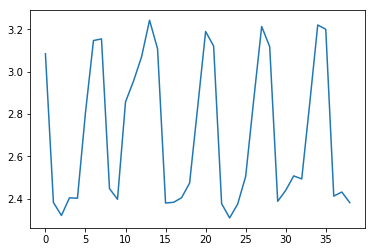

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.823072   
air_0164b9927d20bcc3_2017-04-23              1.349967   
air_0241aa3964b7f861_2017-04-23              2.350981   
air_0328696196e46f18_2017-04-23              1.962163   
air_034a3d5b40d5b1b1_2017-04-23              3.455990   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.190846  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.857299  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.495863  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.114701  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.689632

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l2_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')